# Projet - Apprentissage Profond - Implémentation (Partie CNN)

In [1]:
import gzip
import torch
import matplotlib.pyplot as plt
import torchvision
import torchsummary
import json
import os


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
((data_train,label_train),(data_test,label_test)) = torch.load(gzip.open("data/mnist.pkl.gz"), weights_only=False)

## Étape 1 : Remettre les image en 28x28

In [12]:
data_train_reshaped = data_train.view(-1, 1, 28, 28)
data_test_reshaped = data_test.view(-1, 1, 28, 28)

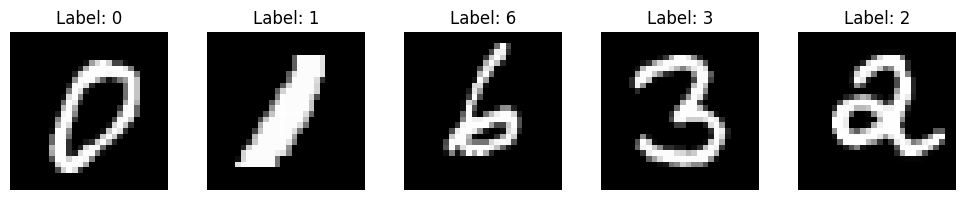

In [ ]:
# Plot the first 5 images
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(data_train_reshaped[i].squeeze(0), cmap='gray')
    plt.title(f"Label: {torch.argmax(label_train[i])}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Étape 2 : Importer le modèle (ResNet-18)

In [34]:
resnet18 = torchvision.models.resnet18(weights="IMAGENET1K_V1")

In [35]:
resnet18.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, 10)

In [22]:
torchsummary.summary(resnet18, input_size = (1, 28, 28))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            3,136
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            25

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            3,136
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            25

## Entraînement du modèle

In [23]:
training_dataset = torch.utils.data.TensorDataset(data_train_reshaped, label_train)
test_dataset = torch.utils.data.TensorDataset(data_test_reshaped, label_test)

In [24]:
# Diviser le jeu de données en sous-ensembles
generator = torch.Generator().manual_seed(42) # Permet de reproduire le même découpement
train_subset, val_subset = torch.utils.data.random_split(training_dataset, [0.8, 0.2], generator=generator)

In [25]:
batch_size = 8
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [26]:
learning_rate = 0.01
loss_func = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=resnet18.parameters(), lr=learning_rate)

### Pré-évaluation du modèle

In [36]:
resnet18.eval()  
acc = 0
total = 0  

with torch.inference_mode():  
    for data, target in val_loader:
        outputs = resnet18(data)  
        
        pred = torch.argmax(outputs, dim=1)  
        true = torch.argmax(target, dim=1)   
        
        # Sum the number of correct predictions
        acc += (pred == true).sum().item() 
        
        # Keep track of the total number of samples
        total += target.size(0)

# Calculate the accuracy
accuracy = acc / total
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.0983


### Entraînement

In [ ]:
for name, param in resnet18.named_parameters():
  if not (name.startswith('layer4') or name.startswith('fc')):
        param.requires_grad = False

In [ ]:
# Définir les hyperparamètres
nb_epochs = 10

# Chemin du fichier pour sauvegarder les métriques
file_path = "data/CNN_train_1.json"

# Initialiser des listes pour suivre les pertes et les précisions pour analyse
training_losses = []
validation_losses = []
validation_accuracies = []

resnet18.to(device)

# Boucle d'entraînement
for epoch in range(nb_epochs):
    resnet18.train()
    epoch_training_loss = 0.0

    # Phase d'entraînement
    for x, t in train_loader:
        x, t = x.to(device), t.to(device)

        # forward pass
        y = resnet18(x)

        # Calculer la perte
        _loss = loss_func(y, t)
        epoch_training_loss += _loss.item()

        # Rétropropagation et optimisation
        optim.zero_grad()  # Réinitialiser les gradients
        _loss.backward()  # Calculer les gradients
        optim.step()  # Mettre à jour les poids du modèle

    # Perte moyenne d'entraînement pour l'époque
    avg_training_loss = epoch_training_loss / len(train_loader)
    training_losses.append(avg_training_loss)

    # Phase de validation
    resnet18.eval()  # Mettre le modèle en mode évaluation

    epoch_val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Désactiver le calcul des gradients pendant la validation
    with torch.inference_mode():
        for data, target in val_loader:  # Utiliser validation_loader pour la validation
            data, target = data.to(device), target.to(device)  # Déplacer les données vers l'appareil

            # Passer en avant (forward pass)
            outputs = resnet18(data)

            # Calculer la perte
            _loss = loss_func(outputs, target)
            epoch_val_loss += _loss.item()

            # Calculer la précision
            predicted_labels = torch.argmax(outputs, dim=1)
            true_labels = torch.argmax(target, dim=1)
            correct_predictions += (predicted_labels == true_labels).sum().item()
            total_predictions += target.size(0)

    # Perte moyenne de validation et précision pour l'époque
    avg_val_loss = epoch_val_loss / len(val_loader)
    validation_losses.append(avg_val_loss)

    accuracy = correct_predictions / total_predictions
    validation_accuracies.append(accuracy)

    # Afficher les métriques pour l'époque en cours
    print(f"Époque {epoch + 1}/{nb_epochs}, Validation loss: {avg_val_loss:.4f}, Validation accuracy: {accuracy:.4f}")

# Précision finale sur le jeu de test
final_correct_predictions = 0
final_total_predictions = 0

resnet18.eval()  # Mettre le modèle en mode évaluation
with torch.inference_mode():
    for data, target in val_loader:  # Utiliser validation_loader ou test_loader pour le test final
        data, target = data.to(device), target.to(device)
        outputs = resnet18(data)
        predicted_labels = torch.argmax(outputs, dim=1)
        true_labels = torch.argmax(target, dim=1)
        final_correct_predictions += (predicted_labels == true_labels).sum().item()
        final_total_predictions += target.size(0)

# Calcul de la précision finale sur le jeu de test
final_test_accuracy = final_correct_predictions / final_total_predictions
print(f"Précision finale: {final_test_accuracy:.4f}")

# Sauvegarder les métriques de performance dans un fichier JSON
result = {
    'hyperparameters': {
        'nb_epochs': nb_epochs,
        'learning_rate': learning_rate,
        'loss_func': str(loss_func.__class__.__name__),
        'optimizer': str(optim.__class__.__name__)
    },
    'training_losses': training_losses,
    'validation_losses': validation_losses,
    'validation_accuracies': validation_accuracies,
    'final_validation_accuracy': final_test_accuracy
}

# # Ajouter les résultats dans le fichier JSON
# with open(file_path, "a") as json_file:
#     # Démarrer le tableau JSON si c'est la première écriture
#     if first_write:
#         json_file.write("[\n")

#     # Écrire les résultats
#     json.dump(result, json_file)

#     # Ajouter une virgule et un saut de ligne, ou fermer le tableau si c'est la première écriture
#     if first_write:
#         json_file.write("\n]")
#     else:
#         json_file.write(",\n")  # Séparer les entrées avec une virgule et un saut de ligne

# print("Résultats sauvegardés dans le fichier JSON.")


Époque 1/10, Validation loss: 0.4679, Validation accuracy: 0.8488
Époque 2/10, Validation loss: 0.4358, Validation accuracy: 0.8572
Époque 3/10, Validation loss: 0.3743, Validation accuracy: 0.8794
Époque 4/10, Validation loss: 0.3304, Validation accuracy: 0.8940
Époque 5/10, Validation loss: 0.3206, Validation accuracy: 0.8982
Époque 6/10, Validation loss: 0.2947, Validation accuracy: 0.9102
Époque 7/10, Validation loss: 0.2828, Validation accuracy: 0.9098
Époque 8/10, Validation loss: 0.2776, Validation accuracy: 0.9116
Époque 9/10, Validation loss: 0.2904, Validation accuracy: 0.9092
Époque 10/10, Validation loss: 0.2783, Validation accuracy: 0.9128
Précision finale: 0.9128


# Évaluation finale

In [39]:
# Importer le modèle

resnet18 = torchvision.models.resnet18()
resnet18.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, 10)

# Charger les poids du modèle entraîné
resnet18.load_state_dict(torch.load("models/CNN_DEFAULT_V1_FROM_SCRATCH_10E.pth", map_location=device))

# Mettre le modèle en mode évaluation
resnet18.eval()

# Calculer la précision finale sur le jeu de test
acc = 0.

with torch.inference_mode():
    # on lit toutes les donnéees de test
    for x,t in test_loader:
      # on calcule la sortie du modèle
      y = resnet18(x)
      # on regarde si la sortie est correcte
      acc += torch.argmax(y,1) == torch.argmax(t,1)
    # on affiche le pourcentage de bonnes réponses
    print(acc/data_test.shape[0])

tensor([0.9924])
